# **Классификация звуков ESC-50**


Набор данных ESC-50 представляет собой набор WAV-файлов. Скачаем его, клонировав репозиторий Git:

In [1]:
!git clone https://github.com/karoldvl/ESC-50

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136 (from 1)
Receiving objects: 100% (4199/4199), 878.79 MiB | 40.98 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


Все WAV-файлы хранятся в аудиокаталоге с именами файлов следующего формата:

`1-100032-A-0.wav`

Нам важно последнее число в имени файла, потому что оно говорит нам,
какому классу был присвоен этот файл звукозаписи. Другие части имени файла нам не важны, но в основном они связаны с набором данных
Freesound, из которого были взяты данные ESC-50.

In [2]:
import os
import random
import pandas as pd
import numpy as np
import IPython.display as display

In [3]:
# audio_files_path = '/content/ESC-50/audio/'
audio_files_path = '/kaggle/working/ESC-50/audio/'

audio_files_list = os.listdir(audio_files_path)

Мы можем загрузить метаинформацию о данных, по которым и увидем, что данные о классе объекта присутствует в названии файла.

In [4]:
meta_info = pd.read_csv('/kaggle/working/ESC-50/meta/esc50.csv')
print('Shape of data:', meta_info.shape)
meta_info.head()

Shape of data: (2000, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
# Создаем словарь из данных в колонках 'target' и 'category'
lbl2cat = meta_info.set_index('target')['category'].to_dict()
print(lbl2cat)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


Если мы хотим прослушать звук в ESC-50, то можем
использовать встроенный аудиопроигрыватель Jupyter, IPython.display.
Audio:

In [6]:
# Выбираем случайный индекс
random_idx = random.randint(0, len(audio_files_list) - 1)
print('audio file name:', audio_files_list[random_idx])
print(
    'object class:   ',
    lbl2cat[int(audio_files_list[random_idx].split('.')[0].split('-')[-1])]
)
display.Audio(audio_files_path + audio_files_list[random_idx])

audio file name: 2-155801-A-11.wav
object class:    sea_waves


## Исследование данных

Мы знаем, что последний набор цифр в каждом имени файла описывает
класс, к которому он принадлежит, поэтому нам нужно получить список
файлов и подсчитать наличие каждого класса:

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

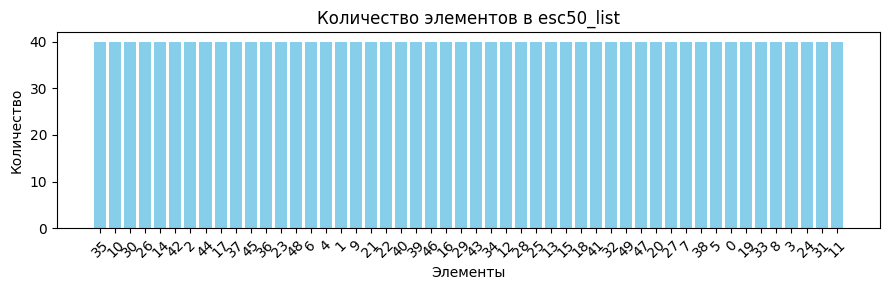

In [8]:
# Создаем список esc50_list
esc50_list = [f.split("-")[-1].replace(".wav", "") for f in audio_files_list]

# Считаем количество каждого элемента
counter = Counter(esc50_list)

# Получаем данные для визуализации
labels = list(counter.keys())
values = list(counter.values())

# Создаем график
plt.figure(figsize=(9, 3))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Элементы')
plt.ylabel('Количество')
plt.title('Количество элементов в esc50_list')
plt.xticks(rotation=45)
plt.tight_layout()  # Чтобы избежать наложения меток
plt.show()

Это тот редкий случай, когда набор данных идеально сбалансирован.

Установим еще несколько библиотек, которые
понадобятся в ближайшее время.

## SoX и LibROSA

Большая часть обработки аудиоданных, которую выполняет torchaudio,
основана на двух других видах программного обеспечения: SoX и LibROSA.

LibROSA — это библиотека Python для аудиоанализа, включающая генерацию мел-спектрограмм, обнаружение
ритмов и даже создание музыки.

SoX — это программа для преобразования WAV-файлов в формат MP3.

In [9]:
# !pip install sox -q

In [9]:
# import sox
import torchaudio
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import torchvision
import librosa
import librosa.display
from PIL import Image
from tqdm import tqdm

## ESC-50 Dataset & DataLoaders

В пользовательском наборе данных должны быть реализованы два метода класса `__getitem__` и `__len__`, чтобы загрузчик данных мог получить пакет тензоров и их маркировки, а также общее количество тензоров в наборе данных. У нас также есть метод `__init__` для настройки пути к файлам, которые будут неоднократно использоваться.

In [10]:
class ESC50(Dataset):
    
    def __init__(self, path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))
    
    def __len__(self):
        return self.length

Нам нужно создать выборки для обучения, валидации и для тестов. На данный момент у нас есть только один каталог со всеми данными. Разделение данных в пропорции 60/20/20 на обучающие, валидационные и тестовые соответствует нашим целям. Итак, мы можем это сделать, взяв случайную выборку из всего набора данных (обеспечив выборку без замены и убедившись, что только что созданные наборы данных сбалансированы), но опять же, набор данных ESC-50 избавляет нас от необходимости выполнять большую работу. Компиляторы набора данных разделили данные на пять равных сбалансированных фолдов, обозначенных первой цифрой в имени файла. У нас будут фолды 1, 2, 3 — набор данных для обучения, 4 — набор данных для валидации и 5 — набор данных для теста. Переместим каждый фолд в каталоги тестирования, обучения и валидации, предварительно создав соответствующие папки:

In [11]:
# !mkdir -p /content/train /content/valid /content/test
# !mv /content/ESC-50/audio/1* /content/train/
# !mv /content/ESC-50/audio/2* /content/train/
# !mv /content/ESC-50/audio/3* /content/train/
# !mv /content/ESC-50/audio/4* /content/valid/
# !mv /content/ESC-50/audio/5* /content/test/

!mkdir -p /kaggle/working/train /kaggle/working/valid
!mv /kaggle/working/ESC-50/audio/1* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/2* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/3* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/4* /kaggle/working/train/
!mv /kaggle/working/ESC-50/audio/5* /kaggle/working/valid/

train_path = '/kaggle/working/train/'
valid_path = '/kaggle/working/valid/'
# test_path = '/kaggle/working/test'

Теперь мы можем создавать отдельные наборы данных и загрузчики:

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bs = 64
PATH_TO_ESC50 = Path.cwd() / 'esc50'

# train_esc50 = ESC50("/content/train")
# valid_esc50 = ESC50("/content/valid")
# test_esc50  = ESC50("/content/test")

train_esc50 = ESC50(train_path)
valid_esc50 = ESC50(valid_path)
# test_esc50  = ESC50(test_path)

train_loader = DataLoader(
    dataset=train_esc50,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
    )

valid_loader = DataLoader(
    dataset=valid_esc50,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
    )

# test_loader  = DataLoader(
#     dataset=test_esc50,
#     batch_size=bs,
#     num_workers=os.cpu_count(),
#     shuffle=False,
#     pin_memory=True
#     )

Данные готовы, займемся моделированием.

## AudioNet

Для первой попытки классификации звуков мы создадим простую CNN-модель, которая в значительной степени будет построена на базе статьи под названием [Very Deep Convolutional Networks For Raw Waveforms](https://arxiv.org/pdf/1610.00087).

In [99]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(1)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

Также нужен оптимизатор и функция потерь.

In [100]:
audionet = AudioNet()
audionet.to(device)
learning_rate = 1e-4
optimizer = optim.Adam(audionet.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
# criterion = nn.CrossEntropyLoss()

# Функция потерь со сглаживанием 
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon=0.1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, output, target):
        num_classes = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = (-log_preds.sum(dim=-1)).mean()
        nll = F.nll_loss(log_preds, target)
        final_loss = self.epsilon * loss / num_classes + (1-self.epsilon) * nll
        return final_loss

criterion = LabelSmoothingCrossEntropyLoss()

In [101]:
def train(model, optimizer, loss_fn, train_loader,
          val_loader, epochs=20, device=device, rep_freq=100, n_rounds=4):
    best_metric = torch.tensor(-9999)
    best_loss = 99999999
    k = 0
    iters = len(train_loader)
    
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    
    for epoch in range(1, epochs+1):
        epoch_train_loss = 0.0
        epoch_valid_loss = 0.0
        is_early_stopping = False
        model.train()
        train_num_correct = 0
        train_num_examples = 0
        for iteration, batch in enumerate(tqdm(train_loader, desc="Training")):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + iteration / iters)
            
            correct = torch.eq(
                torch.max(
                    F.softmax(output, dim=1), dim=1)[1],
                targets
            ).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]
            
            if rep_freq is not None:
                if ((iteration+1) % rep_freq == 0) or (iteration == 0):
                    print("===> Epoch[{}]({}/{}): "
                        "Loss: {:.6f}".format(
                            epoch, iteration+1, len(train_loader), loss.item()
                        ))

        # Считаем среднюю ошибку за эпоху
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        avg_train_accuracy = train_num_correct / train_num_examples
        train_acc_history.append(avg_train_accuracy)
        
        print("===> Epoch {} Complete: "
            "Avg. Loss: {:.4f}".format(epoch, avg_train_loss)
             )
        print(f"===> Avg. Accuracy: {avg_train_accuracy:.4f}")

        model.eval()
        valid_num_correct = 0
        valid_num_examples = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets)
                epoch_valid_loss += loss.data.item()
                correct = torch.eq(
                    torch.max(
                        F.softmax(output, dim=1), dim=1)[1],
                    targets
                ).view(-1)
                valid_num_correct += torch.sum(correct).item()
                valid_num_examples += correct.shape[0]
            
        # Считаем среднюю ошибку за эпоху
        avg_valid_loss = epoch_valid_loss / len(val_loader)
        valid_loss_history.append(avg_valid_loss)
        avg_valid_accuracy = valid_num_correct / valid_num_examples
        valid_acc_history.append(avg_valid_accuracy)
        
        if avg_valid_accuracy > best_metric:
            torch.save(model.state_dict(), "best.pt")
            best_metric = avg_valid_accuracy
            
        if best_loss > round(avg_valid_loss, 6):
            best_loss = round(avg_valid_loss, 6)
            k = 0
        elif k == n_rounds:
            is_early_stopping = True
        else:
            k += 1    
        
        print(f"===> Avg. Loss: {avg_valid_loss:.4f}"
             )
        print(f"===> Avg. Accuracy: {avg_valid_accuracy:.4f}")
        
        torch.save(model.state_dict(), "last.pt")
        
        if is_early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break

    return (
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
    )

In [17]:
print('Number of packages in the train_loader:', len(train_loader))
print('Number of packages in the valid_loader:', len(valid_loader))
# print('Number of packages in the test_loader: ', len(test_loader))

Number of packages in the train_loader: 25
Number of packages in the valid_loader: 7


In [17]:
tr_loss_hist, vl_loss_hist, tr_acc_hist, vl_acc_hist = train(
    audionet, optimizer, criterion,
    train_loader, valid_loader, epochs=30, rep_freq=None
)

Training: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


===> Epoch 1 Complete: Avg. Loss: 3.8622
===> Avg. Accuracy: 0.0456


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


===> Avg. Loss: 3.9183
===> Avg. Accuracy: 0.0200


Training: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


===> Epoch 2 Complete: Avg. Loss: 3.5040
===> Avg. Accuracy: 0.1625


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


===> Avg. Loss: 3.7387
===> Avg. Accuracy: 0.0650


Training: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


===> Epoch 3 Complete: Avg. Loss: 3.2895
===> Avg. Accuracy: 0.2756


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


===> Avg. Loss: 3.6448
===> Avg. Accuracy: 0.0875


Training: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


===> Epoch 4 Complete: Avg. Loss: 3.1299
===> Avg. Accuracy: 0.3569


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


===> Avg. Loss: 3.6076
===> Avg. Accuracy: 0.0800


Training: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


===> Epoch 5 Complete: Avg. Loss: 2.9991
===> Avg. Accuracy: 0.4256


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


===> Avg. Loss: 3.5841
===> Avg. Accuracy: 0.0875


Training: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


===> Epoch 6 Complete: Avg. Loss: 2.9251
===> Avg. Accuracy: 0.4594


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


===> Avg. Loss: 3.5640
===> Avg. Accuracy: 0.0975


Training: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


===> Epoch 7 Complete: Avg. Loss: 2.8658
===> Avg. Accuracy: 0.4863


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


===> Avg. Loss: 3.5608
===> Avg. Accuracy: 0.0925


Training: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


===> Epoch 8 Complete: Avg. Loss: 2.8336
===> Avg. Accuracy: 0.5075


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


===> Avg. Loss: 3.5549
===> Avg. Accuracy: 0.0975


Training: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


===> Epoch 9 Complete: Avg. Loss: 2.8279
===> Avg. Accuracy: 0.5012


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


===> Avg. Loss: 3.5559
===> Avg. Accuracy: 0.1025


Training: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


===> Epoch 10 Complete: Avg. Loss: 2.8276
===> Avg. Accuracy: 0.5000


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


===> Avg. Loss: 3.5367
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s]


===> Epoch 11 Complete: Avg. Loss: 2.6718
===> Avg. Accuracy: 0.5513


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


===> Avg. Loss: 3.5112
===> Avg. Accuracy: 0.1150


Training: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]


===> Epoch 12 Complete: Avg. Loss: 2.5305
===> Avg. Accuracy: 0.5969


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


===> Avg. Loss: 3.4966
===> Avg. Accuracy: 0.1100


Training: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


===> Epoch 13 Complete: Avg. Loss: 2.4285
===> Avg. Accuracy: 0.6225


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


===> Avg. Loss: 3.4827
===> Avg. Accuracy: 0.1075


Training: 100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


===> Epoch 14 Complete: Avg. Loss: 2.3492
===> Avg. Accuracy: 0.6438


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


===> Avg. Loss: 3.4599
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


===> Epoch 15 Complete: Avg. Loss: 2.2792
===> Avg. Accuracy: 0.6631


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


===> Avg. Loss: 3.4649
===> Avg. Accuracy: 0.1175


Training: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


===> Epoch 16 Complete: Avg. Loss: 2.2414
===> Avg. Accuracy: 0.6675


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


===> Avg. Loss: 3.4576
===> Avg. Accuracy: 0.1150


Training: 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


===> Epoch 17 Complete: Avg. Loss: 2.2053
===> Avg. Accuracy: 0.6856


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


===> Avg. Loss: 3.4556
===> Avg. Accuracy: 0.1125


Training: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


===> Epoch 18 Complete: Avg. Loss: 2.1952
===> Avg. Accuracy: 0.6937


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


===> Avg. Loss: 3.4541
===> Avg. Accuracy: 0.1100


Training: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


===> Epoch 19 Complete: Avg. Loss: 2.1882
===> Avg. Accuracy: 0.6906


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


===> Avg. Loss: 3.4525
===> Avg. Accuracy: 0.1100


Training: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


===> Epoch 20 Complete: Avg. Loss: 2.2084
===> Avg. Accuracy: 0.6619


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


===> Avg. Loss: 3.4771
===> Avg. Accuracy: 0.1375


Training: 100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


===> Epoch 21 Complete: Avg. Loss: 2.1292
===> Avg. Accuracy: 0.6913


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


===> Avg. Loss: 3.4394
===> Avg. Accuracy: 0.1175


Training: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


===> Epoch 22 Complete: Avg. Loss: 2.0506
===> Avg. Accuracy: 0.7150


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


===> Avg. Loss: 3.4377
===> Avg. Accuracy: 0.1275


Training: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


===> Epoch 23 Complete: Avg. Loss: 1.9800
===> Avg. Accuracy: 0.7181


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


===> Avg. Loss: 3.4482
===> Avg. Accuracy: 0.1425


Training: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


===> Epoch 24 Complete: Avg. Loss: 1.9337
===> Avg. Accuracy: 0.7400


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


===> Avg. Loss: 3.4552
===> Avg. Accuracy: 0.1375


Training: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


===> Epoch 25 Complete: Avg. Loss: 1.8901
===> Avg. Accuracy: 0.7538


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


===> Avg. Loss: 3.4435
===> Avg. Accuracy: 0.1350


Training: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]


===> Epoch 26 Complete: Avg. Loss: 1.8660
===> Avg. Accuracy: 0.7575


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


===> Avg. Loss: 3.4394
===> Avg. Accuracy: 0.1275


Training: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


===> Epoch 27 Complete: Avg. Loss: 1.8454
===> Avg. Accuracy: 0.7694


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

===> Avg. Loss: 3.4378
===> Avg. Accuracy: 0.1350
Early stopping at epoch 27


In [105]:
def loss_hist_plot(train_loss, val_loss, train_acc, val_acc):
    # Создание графиков
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # График для MSE loss
    axs[0].plot(train_loss, label='Train Loss', color='blue')
    axs[0].plot(val_loss, label='Valid Loss', color='red')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xticks(range(len(train_loss)))
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Cross Entropy Loss History')

    # График для PSNR
    axs[1].plot(train_acc, label='Train Accuracy', color='green')
    axs[1].plot(val_acc, label='Valid Accuracy', color='orange')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xticks(range(len(train_acc)))
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Accuracy History')

    # Показать графики
    plt.tight_layout()
    plt.show()

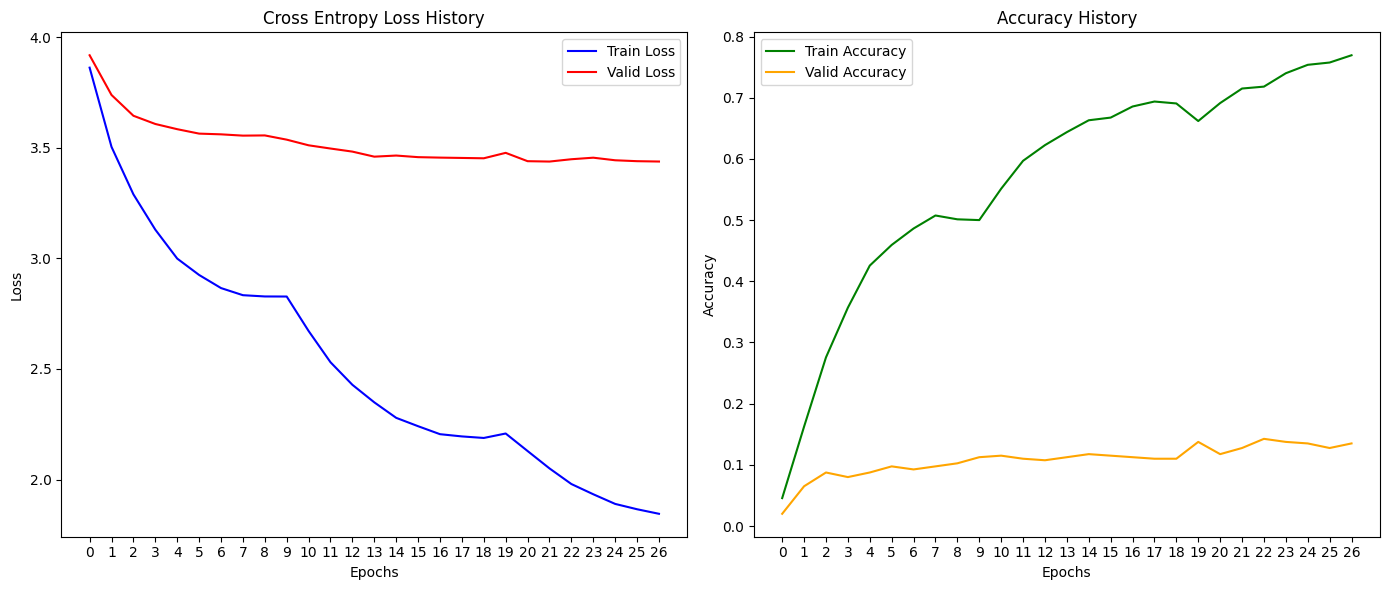

In [19]:
loss_hist_plot(tr_loss_hist, vl_loss_hist, tr_acc_hist, vl_acc_hist)

Модель сильно переобучивается на тренировочных данных. Волнообразность графиков, кстати, получается благодаря планировщику скорости обучения.

In [20]:
print('Max valid accuracy:', max(vl_acc_hist))

Max valid accuracy: 0.1425


Модель выдает 0.1425 точности на валидационной выборке. Это лучше, чем 2 %, на которые мы могли бы рассчитывать, если бы просто рандомно выбирали один из 50 классов. Но, вероятно, результат можно улучшить, если попробовать решить эту задачу не напрямую через данные о звуках.

## Мел-спектрограммы

Традиционно, чтобы попасть в диапазон частот, к звуковому сигналу необходимо применить преобразование Фурье. Мы пойдем немного дальше, создав спектрограммы в мел-шкале. Мел-шкала определяет шкалу высот звука, равноудаленных друг от друга, где 1000 мел = 1000 Гц. Эта шкала обычно используется при обработке аудиоданных, особенно для распознавания и классификации речи. Для создания мел-спектрограммы с помощью LibROSA можно обойтись двумя строчками кода:

random wav file name: 2-117615-B-48.wav
object class: fireworks


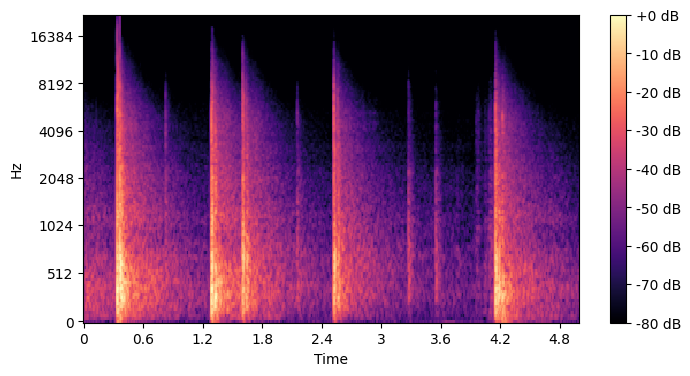

In [19]:
# Выбираем случайный файл
random_wav_file_name = random.choice(os.listdir('/kaggle/working/train'))
# Две строчки кода:
sample_data, sr = librosa.load("/kaggle/working/train/" + random_wav_file_name, sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
# Визуализация логарифмической мел-спектрограммы
print('random wav file name:', random_wav_file_name)
print('object class:',
    lbl2cat[int(random_wav_file_name.split('.')[0].split('-')[-1])]
)
fig, ax = plt.subplots(figsize=(8, 4), sharex=True)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
img = librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
fig.colorbar(img, format="%+2.f dB");

Мы теперь можем создавать представления изображений нашего аудио и использовать предварительно обученную сеть, чтобы значительно улучшить точность при небольшом обучении, используя перенос обучения.

## Новый набор данных

In [14]:
# Функция для получения изображений спектрограмм
def get_spectrograms(path, dpi=100):
    files = os.listdir(path)
    for filename in tqdm(files):
        sample_data, sr = librosa.load(path + filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sr)

        # Сохраняем график в файл
        output_filename = os.path.join(
            path, f"{os.path.splitext(filename)[0]}.png"
        )
        plt.savefig(output_filename, dpi=dpi)
        plt.close()


# Новый класс датасета 
class PrecomputedESC50(Dataset):
    def __init__(self, path, transforms=None):
        files = Path(path).glob('*.png')
        self.items = [(f,int(f.name.split("-")[-1].replace(".png",""))) for f in files]
        self.length = len(self.items)
        if transforms == None:
            self.transforms = transforms.Compose(
                [transforms.ToTensor()]
            )
        else:
            self.transforms = transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.transforms(img), label)
            
    def __len__(self):
        return self.length

Далее наша стретегия следующая: мы оставим наш алгоритм преобразовывать аудиоданные в изображения спектрограмм.

In [15]:
paths = [train_path, valid_path]
for path in paths:
    get_spectrograms(path, dpi=100)

100%|██████████| 400/400 [01:24<00:00,  4.72it/s]


## Предобученный ResNet50

In [16]:
# Датасеты
esc50pre_train = PrecomputedESC50(
    train_path,
    transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]))

esc50pre_valid = PrecomputedESC50(
    valid_path,
    transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]))  

bs = 16

# Загрузчики
esc50_train_loader = DataLoader(
    dataset=esc50pre_train,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
    )

esc50_val_loader  = DataLoader(
    dataset=esc50pre_valid,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
    )

In [22]:
# Загрузка предобученной модели
spec_resnet = models.resnet50(weights='IMAGENET1K_V2')

# Замарозка весов
for param in spec_resnet.parameters():
    param.requires_grad = False

# Замена классификатора
spec_resnet.fc = nn.Sequential(
    nn.Linear(spec_resnet.fc.in_features,500),
    nn.ReLU(), 
    nn.Dropout(), nn.Linear(500,50)
)

spec_resnet.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [23]:
learning_rate = 1e-4
optimizer = optim.Adam(spec_resnet.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropyLoss()

In [24]:
# Обучение классификатора
rn_tr_loss_hist1, rn_vl_loss_hist1, rn_tr_acc_hist1, rn_vl_acc_hist1 = train(
    spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=5, rep_freq=None
)

Training: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


===> Epoch 1 Complete: Avg. Loss: 3.8956
===> Avg. Accuracy: 0.0312


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


===> Avg. Loss: 3.8607
===> Avg. Accuracy: 0.1000


Training: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


===> Epoch 2 Complete: Avg. Loss: 3.8275
===> Avg. Accuracy: 0.0906


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


===> Avg. Loss: 3.7915
===> Avg. Accuracy: 0.1525


Training: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


===> Epoch 3 Complete: Avg. Loss: 3.7485
===> Avg. Accuracy: 0.1175


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s]


===> Avg. Loss: 3.7168
===> Avg. Accuracy: 0.2225


Training: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


===> Epoch 4 Complete: Avg. Loss: 3.6678
===> Avg. Accuracy: 0.1625


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


===> Avg. Loss: 3.6429
===> Avg. Accuracy: 0.2125


Training: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


===> Epoch 5 Complete: Avg. Loss: 3.6063
===> Avg. Accuracy: 0.1994


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]


===> Avg. Loss: 3.5924
===> Avg. Accuracy: 0.2450


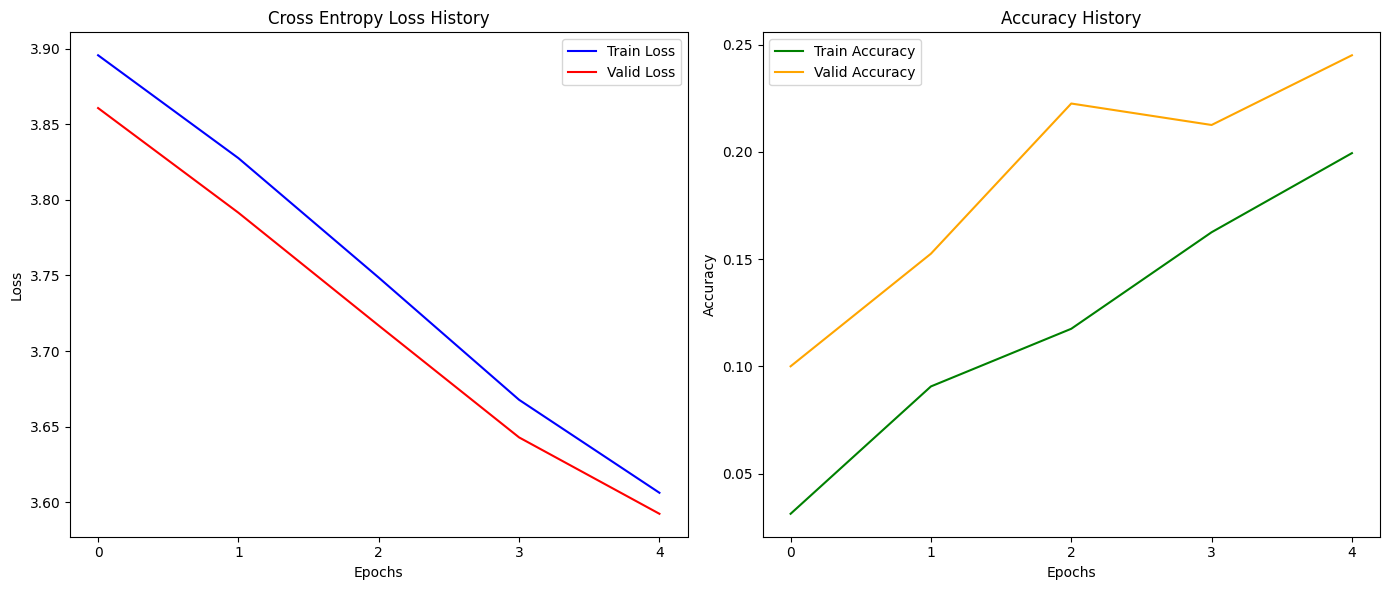

In [25]:
loss_hist_plot(rn_tr_loss_hist1, rn_vl_loss_hist1, rn_tr_acc_hist1, rn_vl_acc_hist1)

Отлично, loss-ы и точности ведут себя согласованно.

In [26]:
# Разморозка весов resnet
for param in spec_resnet.parameters():
    param.requires_grad = True

# Обучение всей сети
rn_tr_loss_hist2, rn_vl_loss_hist2, rn_tr_acc_hist2, rn_vl_acc_hist2 = train(
    spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=20, rep_freq=None
)

Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 1 Complete: Avg. Loss: 2.8687
===> Avg. Accuracy: 0.2856


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s]


===> Avg. Loss: 2.2471
===> Avg. Accuracy: 0.4975


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 2 Complete: Avg. Loss: 2.0111
===> Avg. Accuracy: 0.5787


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


===> Avg. Loss: 1.7988
===> Avg. Accuracy: 0.6500


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 3 Complete: Avg. Loss: 1.5834
===> Avg. Accuracy: 0.7250


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


===> Avg. Loss: 1.5981
===> Avg. Accuracy: 0.6975


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 4 Complete: Avg. Loss: 1.2866
===> Avg. Accuracy: 0.8469


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


===> Avg. Loss: 1.4642
===> Avg. Accuracy: 0.7675


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 5 Complete: Avg. Loss: 1.1414
===> Avg. Accuracy: 0.9131


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


===> Avg. Loss: 1.4138
===> Avg. Accuracy: 0.7650


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 6 Complete: Avg. Loss: 1.0229
===> Avg. Accuracy: 0.9587


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


===> Avg. Loss: 1.3582
===> Avg. Accuracy: 0.8125


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 7 Complete: Avg. Loss: 0.9827
===> Avg. Accuracy: 0.9731


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


===> Avg. Loss: 1.3448
===> Avg. Accuracy: 0.8050


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 8 Complete: Avg. Loss: 0.9535
===> Avg. Accuracy: 0.9775


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]


===> Avg. Loss: 1.3437
===> Avg. Accuracy: 0.7900


Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 9 Complete: Avg. Loss: 0.9505
===> Avg. Accuracy: 0.9788


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


===> Avg. Loss: 1.3446
===> Avg. Accuracy: 0.8025


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 10 Complete: Avg. Loss: 1.0435
===> Avg. Accuracy: 0.9463


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


===> Avg. Loss: 1.4960
===> Avg. Accuracy: 0.7500


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 11 Complete: Avg. Loss: 1.0107
===> Avg. Accuracy: 0.9550


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


===> Avg. Loss: 1.3982
===> Avg. Accuracy: 0.7550


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 12 Complete: Avg. Loss: 0.9157
===> Avg. Accuracy: 0.9806


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]


===> Avg. Loss: 1.3920
===> Avg. Accuracy: 0.7650


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 13 Complete: Avg. Loss: 0.8696
===> Avg. Accuracy: 0.9894


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]


===> Avg. Loss: 1.3235
===> Avg. Accuracy: 0.7825


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 14 Complete: Avg. Loss: 0.8321
===> Avg. Accuracy: 0.9988


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


===> Avg. Loss: 1.2985
===> Avg. Accuracy: 0.8025


Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 15 Complete: Avg. Loss: 0.8093
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s]


===> Avg. Loss: 1.2674
===> Avg. Accuracy: 0.8175


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 16 Complete: Avg. Loss: 0.7996
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


===> Avg. Loss: 1.2785
===> Avg. Accuracy: 0.8025


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 17 Complete: Avg. Loss: 0.7897
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


===> Avg. Loss: 1.2526
===> Avg. Accuracy: 0.8075


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 18 Complete: Avg. Loss: 0.7865
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


===> Avg. Loss: 1.2556
===> Avg. Accuracy: 0.8100


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 19 Complete: Avg. Loss: 0.7873
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


===> Avg. Loss: 1.2508
===> Avg. Accuracy: 0.8125


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 20 Complete: Avg. Loss: 0.8086
===> Avg. Accuracy: 0.9981


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


===> Avg. Loss: 1.3726
===> Avg. Accuracy: 0.7725


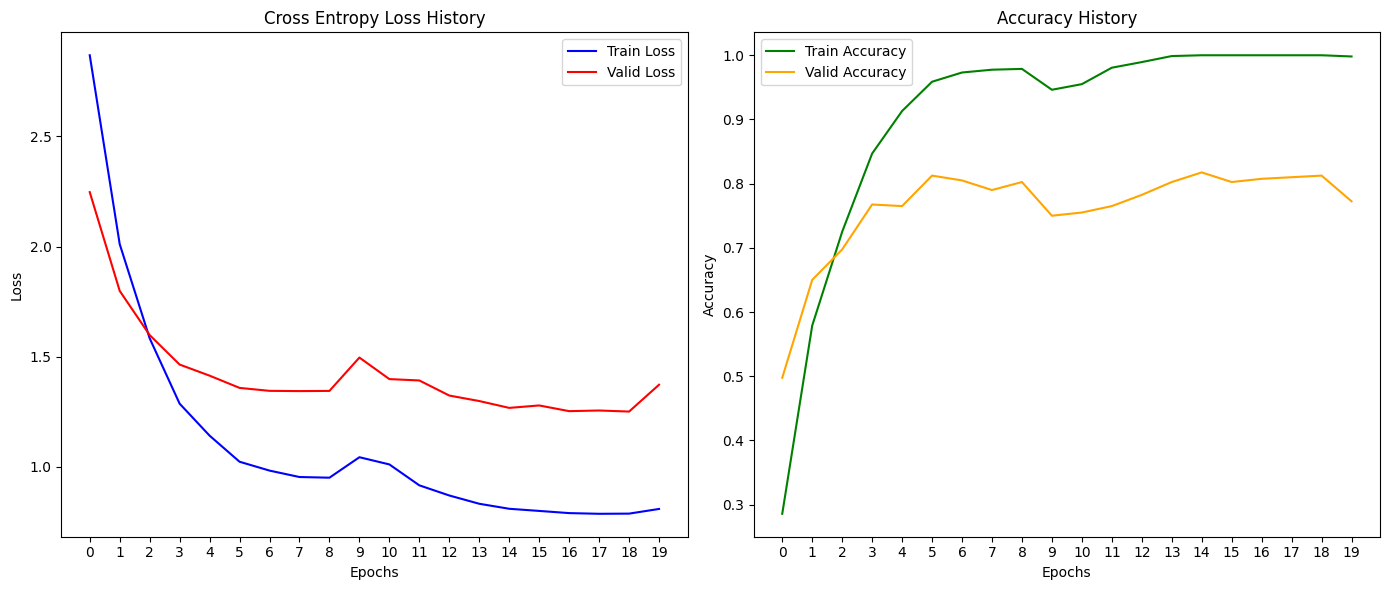

In [27]:
loss_hist_plot(rn_tr_loss_hist2, rn_vl_loss_hist2, rn_tr_acc_hist2, rn_vl_acc_hist2)

In [28]:
print('Max valid accuracy:', max(rn_vl_acc_hist2))

Max valid accuracy: 0.8175


## Аугментация данных

Следующий класс создаёт объект трансформации, который случайным образом наносит частотную маску на наши мел-спетрограммы в пределах заданной ширины.

In [17]:
class FrequencyMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the frequency 
            mask is to be applied.

        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
        start = random.randrange(0, tensor.shape[2])
        end = start + random.randrange(1, self.max_width)
        if self.use_mean:
            tensor[:, start:end, :] = tensor.mean()
        else:
            tensor[:, start:end, :] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')

        return format_string

Посмотрим на работу этой функции.

Также уберём белую рамку с изображений.

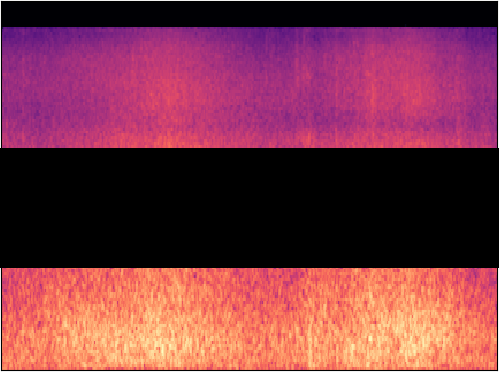

In [94]:
# Собираем все имена изображений
train_imgs_names = [
    file_name for file_name in os.listdir(train_path) if file_name[-3:] == 'png'
]

# Случайная ссылка на одно из изображений
random_path = train_path + random.choice(train_imgs_names)
# Получаем изображение
img = Image.open(path).convert('RGB')

# Преобразование изображения в тензор
transform = transforms.ToTensor()
img_tensor = transform(img)

# Найдем маску пикселей, где нет белого (RGB: [1, 1, 1])
non_white_mask = (img_tensor != 1.0).any(dim=0)

# Найдем индексы, где маска истинна
non_white_indices = torch.where(non_white_mask)

# Определим границы области без белого
top, bottom = non_white_indices[0].min().item(), non_white_indices[0].max().item()
left, right = non_white_indices[1].min().item(), non_white_indices[1].max().item()

# Обрезка изображения по границам
cropped_img_tensor = img_tensor[:, top:bottom+1, left:right+1]

transforms.Compose([
    FrequencyMask(max_width=200, use_mean=False),
    transforms.ToPILImage()
])(cropped_img_tensor)

Как видим, присутствует широкая чёрная полоса по оси частот.

Следующая класс трансформаций - наложение случайной маски на временную шкалу также по заданной ширине.

In [56]:
class TimeMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     TimeMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the time mask 
            is to be applied.

        Returns:
            Tensor: Transformed image with Time Mask.
        """
        start = random.randrange(0, tensor.shape[1])
        end = start + random.randrange(0, self.max_width)
        if self.use_mean:
            tensor[:, :, start:end] = tensor.mean()
        else:
            tensor[:, :, start:end] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')
        return format_string

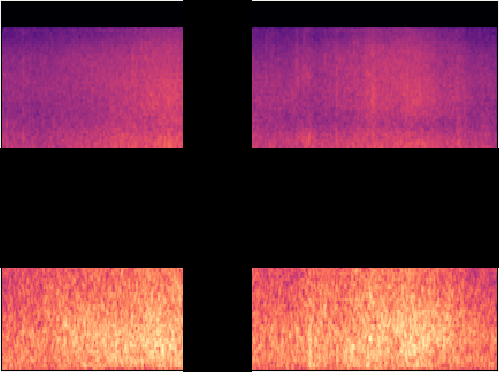

In [95]:
transforms.Compose([
    TimeMask(max_width=200, use_mean=False),
    transforms.ToPILImage()
])(cropped_img_tensor)

Теперь у нас добавилась также маска на шкалу времени.

In [85]:
class PrecomputedTransformESC50(Dataset):
    def __init__(self, path):
        files = Path(path).glob('*.png')
        self.items = [(f,f.name.split("-")[-1].replace(".png", "")) for f in files]
        self.length = len(self.items)
        self.transforms = transforms.Compose([
            transforms.RandomApply([FrequencyMask(max_width=200)], p=0.5),
            transforms.RandomApply([TimeMask(max_width=200)], p=0.5),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        # Получаем изображение
        img = Image.open(filename).convert('RGB')

        # Преобразование изображения в тензор
        transform = transforms.ToTensor()
        img_tensor = transform(img)

        # Найдем маску пикселей, где нет белого (RGB: [1, 1, 1])
        non_white_mask = (img_tensor != 1.0).any(dim=0)

        # Найдем индексы, где маска истинна
        non_white_indices = torch.where(non_white_mask)

        # Определим границы области без белого
        top, bottom = non_white_indices[0].min().item(), non_white_indices[0].max().item()
        left, right = non_white_indices[1].min().item(), non_white_indices[1].max().item()

        # Обрезка изображения по границам
        cropped_img_tensor = img_tensor[:, top:bottom+1, left:right+1]
        
        return (self.transforms(cropped_img_tensor), label)
        
    def __len__(self):
        return self.length

In [86]:
# Датасеты
pt_esc50pre_train = PrecomputedTransformESC50(train_path)
pt_esc50pre_valid = PrecomputedTransformESC50(valid_path)  
bs = 16

# Загрузчики
pt_esc50_train_loader = DataLoader(
    dataset=pt_esc50pre_train,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
    )

pt_esc50_val_loader  = DataLoader(
    dataset=pt_esc50pre_valid,
    batch_size=bs,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
    )

In [96]:
# Загрузка предобученной модели
pt_spec_resnet = models.resnet50(weights='IMAGENET1K_V2')

# Замарозка весов
for param in pt_spec_resnet.parameters():
    param.requires_grad = False

# Замена классификатора
pt_spec_resnet.fc = nn.Sequential(
    nn.Linear(pt_spec_resnet.fc.in_features,500),
    nn.ReLU(), 
    nn.Dropout(), nn.Linear(500,50)
)

pt_spec_resnet.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [102]:
learning_rate = 1e-4
optimizer = optim.Adam(pt_spec_resnet.parameters(), weight_decay=1e-5, lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropyLoss()

In [103]:
# Обучение классификатора
pt_rn_tr_loss_hist1, pt_rn_vl_loss_hist1, pt_rn_tr_acc_hist1, pt_rn_vl_acc_hist1 = train(
    pt_spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=5, rep_freq=None
)

Training: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


===> Epoch 1 Complete: Avg. Loss: 3.8976
===> Avg. Accuracy: 0.0344


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


===> Avg. Loss: 3.8605
===> Avg. Accuracy: 0.0850


Training: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


===> Epoch 2 Complete: Avg. Loss: 3.8312
===> Avg. Accuracy: 0.0925


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


===> Avg. Loss: 3.7901
===> Avg. Accuracy: 0.1825


Training: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


===> Epoch 3 Complete: Avg. Loss: 3.7504
===> Avg. Accuracy: 0.1338


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


===> Avg. Loss: 3.7124
===> Avg. Accuracy: 0.1750


Training: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


===> Epoch 4 Complete: Avg. Loss: 3.6758
===> Avg. Accuracy: 0.1675


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


===> Avg. Loss: 3.6534
===> Avg. Accuracy: 0.2400


Training: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


===> Epoch 5 Complete: Avg. Loss: 3.6149
===> Avg. Accuracy: 0.1944


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


===> Avg. Loss: 3.6055
===> Avg. Accuracy: 0.2500


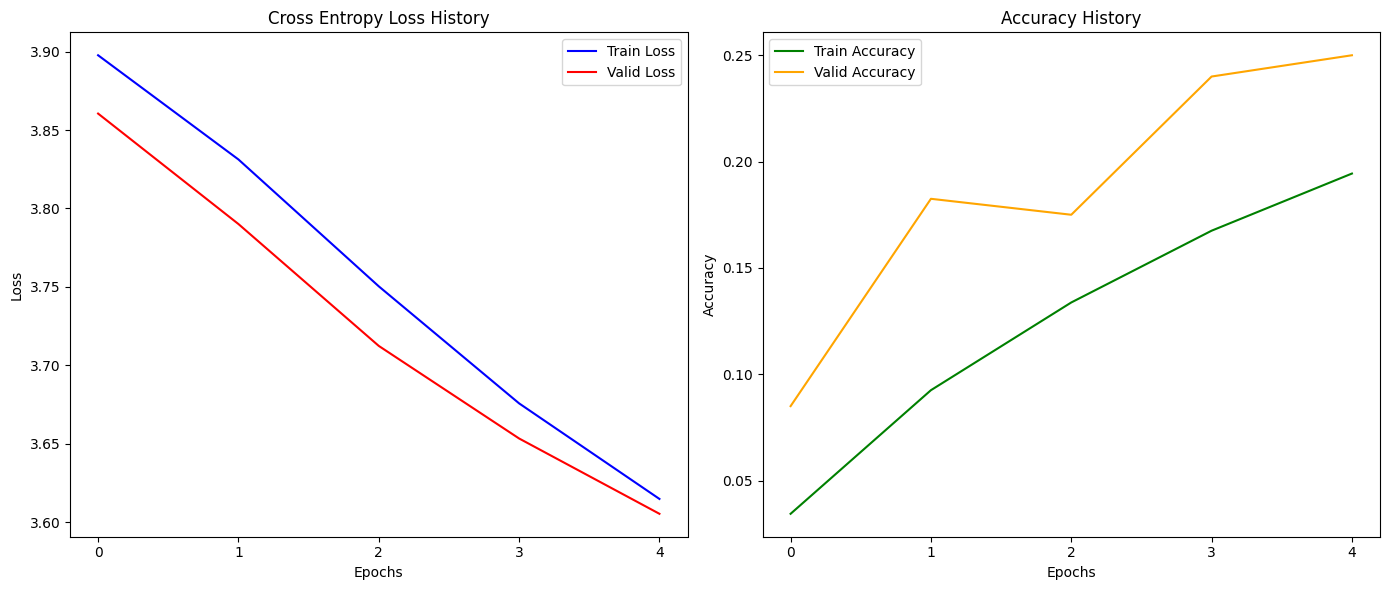

In [106]:
loss_hist_plot(pt_rn_tr_loss_hist1, pt_rn_vl_loss_hist1, pt_rn_tr_acc_hist1, pt_rn_vl_acc_hist1)

In [107]:
# Разморозка весов resnet
for param in pt_spec_resnet.parameters():
    param.requires_grad = True

# Обучение всей сети
pt_rn_tr_loss_hist2, pt_rn_vl_loss_hist2, pt_rn_tr_acc_hist2, pt_rn_vl_acc_hist2 = train(
    pt_spec_resnet, optimizer, criterion,
    esc50_train_loader, esc50_val_loader,
    epochs=20, rep_freq=None
)

Training: 100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


===> Epoch 1 Complete: Avg. Loss: 2.8556
===> Avg. Accuracy: 0.2994


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


===> Avg. Loss: 2.2747
===> Avg. Accuracy: 0.4900


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 2 Complete: Avg. Loss: 2.0413
===> Avg. Accuracy: 0.5563


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


===> Avg. Loss: 1.7816
===> Avg. Accuracy: 0.6525


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 3 Complete: Avg. Loss: 1.5676
===> Avg. Accuracy: 0.7369


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


===> Avg. Loss: 1.5938
===> Avg. Accuracy: 0.7275


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 4 Complete: Avg. Loss: 1.2949
===> Avg. Accuracy: 0.8494


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s]


===> Avg. Loss: 1.5290
===> Avg. Accuracy: 0.7450


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 5 Complete: Avg. Loss: 1.1467
===> Avg. Accuracy: 0.9062


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


===> Avg. Loss: 1.4225
===> Avg. Accuracy: 0.7625


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 6 Complete: Avg. Loss: 1.0182
===> Avg. Accuracy: 0.9619


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s]


===> Avg. Loss: 1.3844
===> Avg. Accuracy: 0.7675


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 7 Complete: Avg. Loss: 0.9824
===> Avg. Accuracy: 0.9706


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s]


===> Avg. Loss: 1.3712
===> Avg. Accuracy: 0.7750


Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 8 Complete: Avg. Loss: 0.9709
===> Avg. Accuracy: 0.9756


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


===> Avg. Loss: 1.3667
===> Avg. Accuracy: 0.7800


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 9 Complete: Avg. Loss: 0.9524
===> Avg. Accuracy: 0.9775


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


===> Avg. Loss: 1.3614
===> Avg. Accuracy: 0.7700


Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 10 Complete: Avg. Loss: 1.0921
===> Avg. Accuracy: 0.9219


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


===> Avg. Loss: 1.5195
===> Avg. Accuracy: 0.7325


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 11 Complete: Avg. Loss: 1.0069
===> Avg. Accuracy: 0.9494


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


===> Avg. Loss: 1.4698
===> Avg. Accuracy: 0.7550


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 12 Complete: Avg. Loss: 0.9273
===> Avg. Accuracy: 0.9769


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s]


===> Avg. Loss: 1.4272
===> Avg. Accuracy: 0.7600


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 13 Complete: Avg. Loss: 0.8724
===> Avg. Accuracy: 0.9944


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s]


===> Avg. Loss: 1.4044
===> Avg. Accuracy: 0.7575


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 14 Complete: Avg. Loss: 0.8358
===> Avg. Accuracy: 0.9981


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


===> Avg. Loss: 1.3457
===> Avg. Accuracy: 0.7775


Training: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


===> Epoch 15 Complete: Avg. Loss: 0.8103
===> Avg. Accuracy: 0.9994


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


===> Avg. Loss: 1.3181
===> Avg. Accuracy: 0.7725


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 16 Complete: Avg. Loss: 0.8010
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


===> Avg. Loss: 1.3284
===> Avg. Accuracy: 0.7900


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 17 Complete: Avg. Loss: 0.7936
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]


===> Avg. Loss: 1.3391
===> Avg. Accuracy: 0.7750


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 18 Complete: Avg. Loss: 0.7904
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


===> Avg. Loss: 1.3152
===> Avg. Accuracy: 0.7925


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 19 Complete: Avg. Loss: 0.7840
===> Avg. Accuracy: 1.0000


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s]


===> Avg. Loss: 1.3293
===> Avg. Accuracy: 0.7800


Training: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


===> Epoch 20 Complete: Avg. Loss: 0.8166
===> Avg. Accuracy: 0.9969


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


===> Avg. Loss: 1.4646
===> Avg. Accuracy: 0.7350


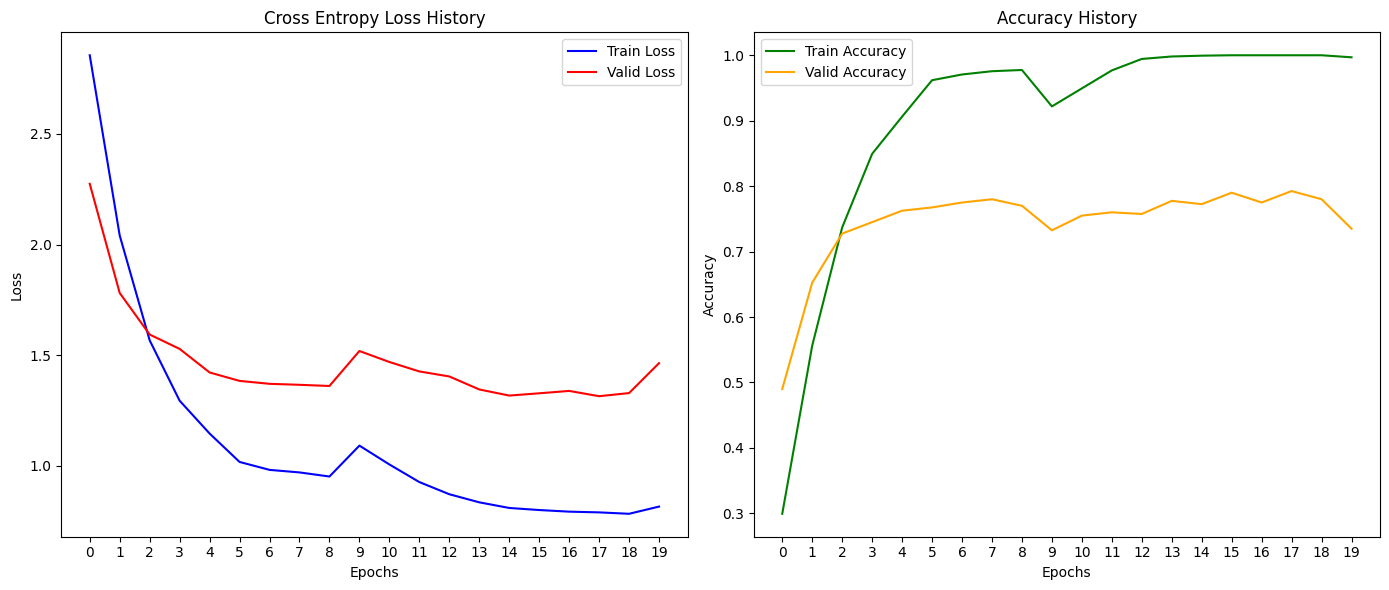

In [108]:
loss_hist_plot(pt_rn_tr_loss_hist2, pt_rn_vl_loss_hist2, pt_rn_tr_acc_hist2, pt_rn_vl_acc_hist2)

In [110]:
print('Max valid accuracy:', max(pt_rn_vl_acc_hist2))

Max valid accuracy: 0.7925


Наша аугментация конкретной пользы не принесла, похоже.